<img style="float: left;" alt="Drawing" src="./figures/3Di_beeldmerk_RGB.png" width="100"/> </td>
<img style="float: right;" alt="Drawing" src="./figures/lizard-beeldmerk-donker-groen.jpg" width="80"/> </td>                                            

## Download the maximum waterdepth raster of a 3Di-simulation

Welcome! In this notebook we will show how you can locally download a maximum waterdepth raster from your 3Di-simulation. The raster will be downloaded by using the API of Lizard. The following steps will be taken according to an example of an 3Di model:
- **step 1:** Search for your 3Di-scenario and find your maximum water level raster uuid
- **step 2:** Determine the extent of the raster to be downloaded (total defined raster or by using a shapefile)
- **step 3:** Define the cell size of the raster to be downloaded
- **step 4:** Download the raster with the defined extent and cell size, and its projection
- **step 5:** Visualise the raster in a figure for a first impression

Import all required packages:

In [86]:
from datetime import datetime
from getpass import getpass
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
from pathlib import Path
import numpy as np
import geopandas as gpd
import pyproj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial
import webbrowser
import rasterio
from rasterio.plot import show

import warnings
warnings.filterwarnings("ignore")
import contextily as ctx

### Define the  variables of the to be downloaded raster:

In [56]:
#define here in which projection you would like to download your raster
projection_raster = "epsg:28992"

#define here the path of the shapefile and read this shapefile to determine the crs
path_shapefile = "./shapefile/boundaries_shapefile.shp"
shapefile = gpd.read_file(path_shapefile)
print (shapefile.crs)

#define here what the pixelsize of your raster should be (note in this tutorial we choose only square pixels)
pixelsize_x = 10
pixelsize_y = pixelsize_x

#define here if you would like to download the raster based on a predefined shapefile or the extent of the raster itself
based_on_shapefile = 'no'  #if no then based on extent, if yes then based on shapefile

#define here the scenario name of the 3Di scenario
scenario_name = 'banjul'

epsg:28992


### Step 1: Search for your 3Di-scenario and find your maximum water level raster uuid

Provide credentials to connect with the Lizard API - by using an API key:

In [57]:
username = '__key__'
password = 'kuXO19bW.bN20PPqQRXimoinm90vmc9eZ2LmIhnWU'
headers = {
            "username": username,
            "password": password,
            "Content-Type": "application/json",
        }

Search for your 3Di scenario (v2_bergermeer) and look up all the rasters from the simulation:

In [58]:
url = 'https://nens.lizard.net/api/v4/rasters/?name__icontains={}&page_size=10'.format(scenario_name)
raster_results = pd.DataFrame(requests.get(url=url, headers=headers).json()['results'])
raster_results = raster_results[['id', 'uuid', 'url', 'name', 'projection', 'spatial_bounds', 'options']]
raster_results

,id,uuid,url,name,projection,spatial_bounds,options
0,115148,0b38bc91-3867-43a8-bdd7-fe1e3e49d3e2,https://nens.lizard.net/api/v4/rasters/0b38bc9...,banjul_test_remo_emile_poging2 Water depth (ti...,EPSG:32628,"{'west': -16.800874479886925, 'east': -16.5489...",{'styles': 'Blues:0.0:2.0'}
1,115149,81179018-95b8-4b6b-92b5-453e95264a60,https://nens.lizard.net/api/v4/rasters/8117901...,banjul_test_remo_emile_poging2 Max water depth,EPSG:32628,"{'west': -16.800874479886925, 'east': -16.5489...",{'styles': 'Blues:0.0:2.0'}
2,115150,c3825902-6016-4be1-9633-cbd07aa0daa4,https://nens.lizard.net/api/v4/rasters/c382590...,banjul_test_remo_emile_poging2 Flood hazard ra...,EPSG:32628,"{'west': -16.800874479886925, 'east': -16.5489...",{'styles': '3di-fhr:0:2'}
3,115151,6f0c8ddd-1308-45f4-9e0f-06484d3b8faa,https://nens.lizard.net/api/v4/rasters/6f0c8dd...,banjul_test_remo_emile_poging2 Rate of rise,EPSG:32628,"{'west': -16.800874479886925, 'east': -16.5489...",{'styles': '3di-rise-vel:0:1'}
4,115152,d1c41ea4-49d8-4783-8763-f2c4bc044940,https://nens.lizard.net/api/v4/rasters/d1c41ea...,banjul_test_remo_emile_poging2 Water level (ti...,EPSG:32628,"{'west': -16.800874479886925, 'east': -16.5489...",{'styles': 'Spectral:-10:20'}
5,115153,ec3377f0-de99-4b69-90ee-f195107e963a,https://nens.lizard.net/api/v4/rasters/ec3377f...,banjul_test_remo_emile_poging2 Max water level,EPSG:32628,"{'west': -16.800874479886925, 'east': -16.5489...",{'styles': 'Spectral:-10:20'}
6,115154,bc282d68-9ef1-44ae-8fba-222482c6a208,https://nens.lizard.net/api/v4/rasters/bc282d6...,banjul_test_remo_emile_poging2 Max flow velocity,EPSG:32628,"{'west': -16.800874479886925, 'east': -16.5489...",{'styles': '3di-ucr-max:0:3'}
7,115155,7d1d3a76-fa29-4175-b56f-de092a54b789,https://nens.lizard.net/api/v4/rasters/7d1d3a7...,banjul_test_remo_emile_poging2 Rain,EPSG:32628,"{'west': -16.800891248362333, 'east': -16.5482...",{'styles': 'radar-hour'}


Search for the maximum waterdepth raster and its uuid:

In [59]:
max_waterdepth_raster = raster_results[raster_results['name'].str.contains('Max water depth')]
max_waterdepth_raster

,id,uuid,url,name,projection,spatial_bounds,options
1,115149,81179018-95b8-4b6b-92b5-453e95264a60,https://nens.lizard.net/api/v4/rasters/8117901...,banjul_test_remo_emile_poging2 Max water depth,EPSG:32628,"{'west': -16.800874479886925, 'east': -16.5489...",{'styles': 'Blues:0.0:2.0'}


In [60]:
# Define the uuid of the max_waterlevel_raster
uuid = max_waterdepth_raster['uuid'].iloc[0]

raster_url = "https://nens.lizard.net/api/v4/rasters/{}".format(uuid)
raster_url

'https://nens.lizard.net/api/v4/rasters/81179018-95b8-4b6b-92b5-453e95264a60'

### Step 2: Determine the extent of the raster to be downloaded by using a shapefile or the bounds of the raster itself

    * a)shapefile
    
    * b)bounds of the raster itself

#### Step 2a): Determine the extent of the raster to be downloaded by using a shapefile

For example: 
<table><tr>
<td> <img alt="Drawing" src="./figures/chosen_shapefile_v1.PNG" width="400"/> </td>
</tr></table>

Determine the bounds of the shapefile:

In [61]:
if based_on_shapefile == 'yes':
    print ('You have chosen to download the raster based on a chosen predefined shapefile')
    x1= shapefile.bounds['minx'].iloc[0]
    x2 =shapefile.bounds['maxx'].iloc[0]
    y1 = shapefile.bounds['miny'].iloc[0]
    y2 = shapefile.bounds['maxy'].iloc[0]



    if str(shapefile.crs) == projection_raster:
        bbox = '{}, {}, {}, {}'.format(x1,y1,x2,y2)
        bbox = bbox
        geom = {'type': 'Polygon',
        'coordinates': [[[x1, y1], [x2,y1],[x2, y2], [x1, y2],
                         [x1, y1]]]}
        print ('the crs of the shapefile is in:',shapefile.crs)
        print (bbox)
        
        
        #surface_area
        s = shape(geom)
        proj = partial(pyproj.transform, pyproj.Proj(init=shapefile.crs),
               pyproj.Proj(init='epsg:28992'))

        s_new = transform(proj, s)
        surface_area = s_new.area
        print (surface_area)
        
        
    else:
        print ('the crs of the shapefile needs to be converted to the same projection of the raster to be downloaded:')
        geom = {'type': 'Polygon',
        'coordinates': [[[x1, y1], [x2,y1],[x2, y2], [x1, y2],
                         [x1, y1]]]}
        s=shape(geom)
        #surface area
        proj = partial(pyproj.transform, pyproj.Proj(init=shapefile.crs),
               pyproj.Proj(init='epsg:28992'))

        s_new = transform(proj, s)
        surface_area = s_new.area
        
        x1 = s_new.bounds[0]
        x2 = s_new.bounds[2]
        y1 = s_new.bounds[1]
        y2 = s_new.bounds[3]

        geom = {'type': 'Polygon',
        'coordinates': [[[x1, y1], [x2,y1],[x2, y2], [x1, y2],
                         [x1, y1]]]}
        surface_area = shape(geom).area
        print (surface_area)
        
        #bbox transformation
        s = shape(geom)
        proj = partial(pyproj.transform, pyproj.Proj(init='epsg:28992'),
               pyproj.Proj(init=projection_raster))

        s_new = transform(proj, s)
        
        x1 = s_new.bounds[0]
        x2 = s_new.bounds[2]
        y1 = s_new.bounds[1]
        y2 = s_new.bounds[3]
        bbox = '{}, {}, {}, {}'.format(x1, y1, x2, y2)
        print (bbox)
        
else:
    print ('You have chosen to download the raster based on the extent itself and therefore we skip this step')


You have chosen to download the raster based on the extent itself and therefore we skip this step


#### Step 2b): Determine the extent of the raster to be downloaded by using the extent of the raster itself

Look up the raster with the Lizard API and define its spatial bounds as given. Note that these bounds are in epsg:4326 and need to be converted to the desired projection of the to be downloaded raster:

In [62]:
if based_on_shapefile == 'no':
    print ('You have chosen to download the raster based on the extent of the raster itself')
    raster_url = "https://nens.lizard.net/api/v4/rasters/{}/".format(uuid)
    r = requests.get(url=raster_url, headers=headers)
    spatial_bounds = r.json()['spatial_bounds'] #these bounds are in epsg4326
    x1 = spatial_bounds['west']
    x2 = spatial_bounds['east']
    y1 = spatial_bounds['south']
    y2 = spatial_bounds['north']

    bbox = '{}, {}, {}, {}'.format(x1,y1,x2,y2)
    print (r.json())
    print (bbox)
    
    #convert the bounds with epsg:4326 to the desired projection (projection_raster)
    geom = {'type': 'Polygon',
        'coordinates': [[[x1, y1], [x2,y1],[x2, y2], [x1, y2],
                         [x1, y1]]]}

    s = shape(geom)
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init=projection_raster))
    s_new = transform(proj, s)

    x1 = s_new.bounds[0]
    x2 = s_new.bounds[2]
    y1 = s_new.bounds[1]
    y2 = s_new.bounds[3]

    bbox = '{}, {}, {}, {}'.format(x1, y1, x2, y2)
    print (bbox)
    
    #for the surface area
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:28992'))
    s_new = transform(proj, s)
    surface_area = s_new.area

    print (surface_area)
else:
    print ('You have chosen to download the raster based on a predefined shapefile and therefore we skip this step')

You have chosen to download the raster based on the extent of the raster itself
{'id': 115149, 'uuid': '81179018-95b8-4b6b-92b5-453e95264a60', 'url': 'https://nens.lizard.net/api/v4/rasters/81179018-95b8-4b6b-92b5-453e95264a60/', 'last_modified': '2021-03-05T11:06:51.732997Z', 'created': '2021-03-05T11:06:51.733091Z', 'organisation': {'url': 'https://nens.lizard.net/api/v4/organisations/61f5a464-c350-44c1-9bc7-d4b42d7f58cb/', 'uuid': '61f5a464-c350-44c1-9bc7-d4b42d7f58cb', 'name': 'Nelen & Schuurmans'}, 'access_modifier': 'Private', 'supplier': 'remo.vantilburg', 'shared_with': [], 'writable': True, 'is_geoblock': True, 'source': {'name': 'MaskBelow', 'graph': {'Snap': ['dask_geomodeling.raster.temporal.Snap', 'LizardRasterSource_1', 'LizardRasterSource_2'], 'Subtract': ['dask_geomodeling.raster.elemwise.Subtract', 'LizardRasterSource_2', 'Snap'], 'MaskBelow': ['dask_geomodeling.raster.misc.MaskBelow', 'Subtract', 0], 'LizardRasterSource_1': ['lizard_nxt.blocks.LizardRasterSource', '54

### Step 3: Define the cell size of the raster to be downloaded:

First calculate the surface area of the extent:

Calculate the number of pixels needed in horizontal and vertical direction if you choose a pixel of 0.5 by 0.5 (one cell size is 0.25 m2).

In [63]:
pixel_area = pixelsize_x * pixelsize_y
total_pixels = surface_area / pixel_area
pixels_in_horizontal_direction = np.round(np.sqrt(total_pixels))
pixels_in_vertical_direction = pixels_in_horizontal_direction
pixels_in_vertical_direction

3016.0

*Note that if you do not define the number of pixels needed in horizontal and vertical direction, its default is 256 in both directions.*

### Step 4: Download the raster with the defined extent and cell size, and its projection

In [64]:
raster_url = "https://nens.lizard.net/api/v4/rasters/"
get_url = f"{raster_url}{uuid}/data/" # we use the data endpoint

# request the data
r = requests.get(
            url=get_url,
            headers=headers,
            params=
            {"bbox": bbox,
             "format": 'geotiff', #only geotiff is supported
             'projection': projection_raster,
             'async': True,
             'width':pixels_in_vertical_direction,
             'height':pixels_in_horizontal_direction
            }
)

task = r.json()
task_url = task['url']
r_geotiff= requests.get(url=task_url, headers=headers)
print (r_geotiff.json())
geotiff_raster = r_geotiff.json()['result']

{'uuid': '64c63351-f614-4d34-902e-35ba5403e18a', 'url': 'https://nens.lizard.net/api/v4/tasks/64c63351-f614-4d34-902e-35ba5403e18a/', 'status': 'STARTED', 'result': None, 'detail': None}


A task has started to download the maximum water depth raster with its defined bbox, format, projection and horizontal/vertical pixels. When the task has finished, you will see at status: SUCCESS

In [ ]:
r_geotiff = requests.get(url=task_url, headers=headers).json()
print (r_geotiff)

        

We can now locally download this raster:

In [67]:
geotiff_raster = r_geotiff['result']
#run this cell to locally download this raster
webbrowser.open(geotiff_raster, autoraise=True)

True

In your Downloads folder you will find the geotiff.

### Step 4: Visualise the raster in a figure for a first impression

Open the raster:

In [68]:
img = rasterio.open(geotiff_raster).read()
print (img.max())
print (img.min())

3.4028235e+38
0.0


Check the amount of pixels in each direction:

In [69]:
img.shape

(1, 3016, 3016)

Plot the raster in a figure:

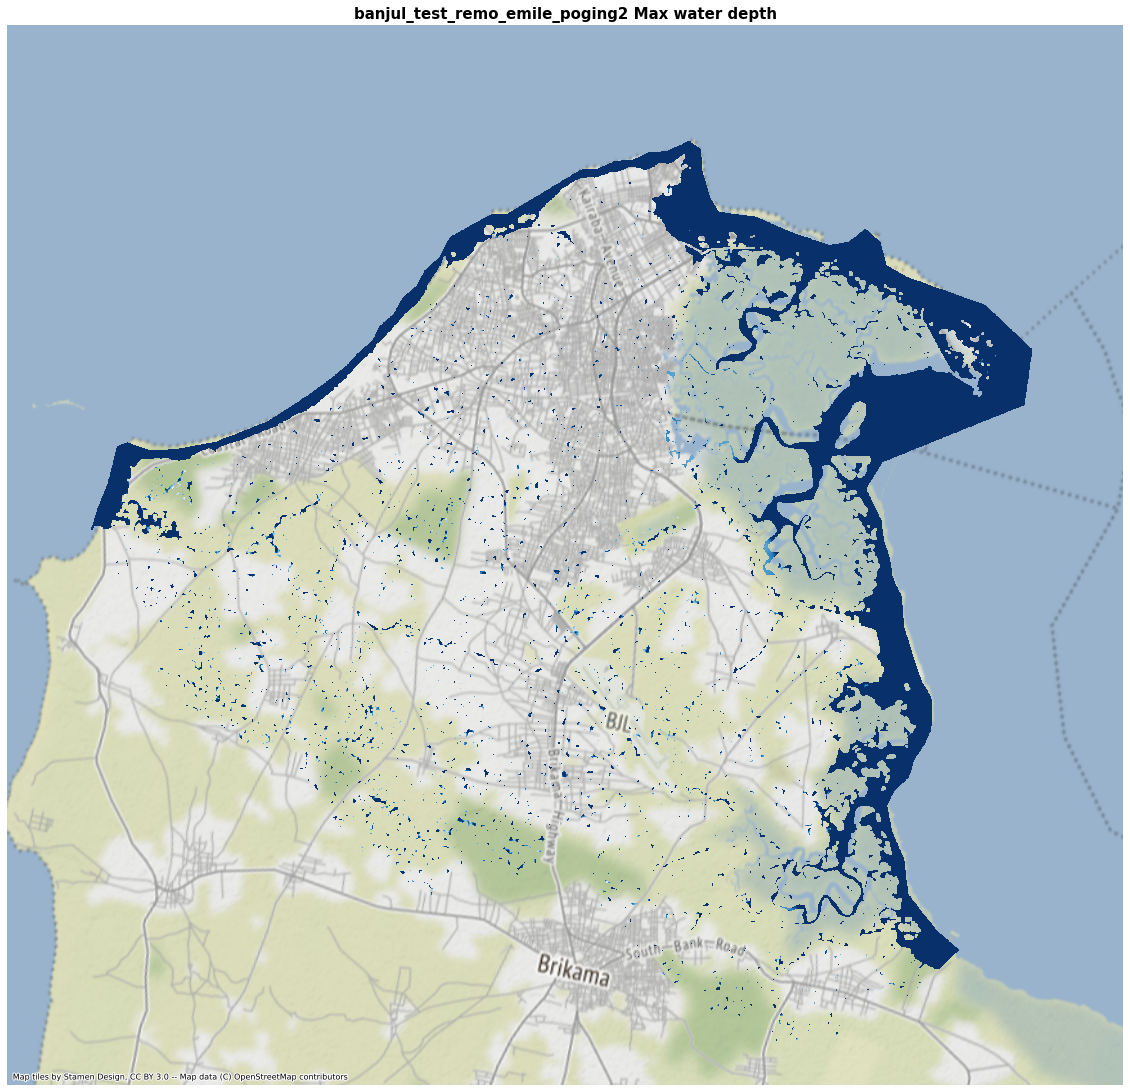

In [88]:
f, ax = plt.subplots(figsize=(20,20))
img = rasterio.open(geotiff_raster)

raster = show(img, ax=ax, cmap='Blues', vmin=0, vmax=0.3)
ctx.add_basemap(raster, crs=projection_raster, )
show(img, ax=ax, cmap='Blues', vmin=0, vmax=0.3)


plt.title(str(max_waterdepth_raster['name'].iloc[0]), fontweight='bold', fontsize=15)
plt.axis('off')
plt.show()  